# Age at first marriage


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from lifelines import KaplanMeierFitter

from utils import decorate
from utils import value_counts
from utils import resample_by_cycle
from utils import round_into_bins
from utils import remove_spines

from empiricaldist import Pmf, Cdf

random_seed = 1

<IPython.core.display.Javascript object>

In [4]:
# Make the figures smaller to save some screen real estate.
plt.rcParams["figure.dpi"] = 75
plt.rcParams["figure.figsize"] = [5, 3.7]

<IPython.core.display.Javascript object>

In [5]:
from utils import set_palette, resample_by_cycle

<IPython.core.display.Javascript object>

## Age at first marriage, female respondents

Load the data cleaned in `clean_nsfg.ipynb` and run the analysis with `lifelines`

In [6]:
%time unweighted = pd.read_hdf('FemMarriageData.hdf', 'FemMarriageData')
unweighted.shape

CPU times: user 55.8 ms, sys: 19.9 ms, total: 75.7 ms
Wall time: 81 ms


(75769, 43)

<IPython.core.display.Javascript object>

In [7]:
evrmarry = unweighted["evrmarry"]
value_counts(evrmarry)

evrmarry
False    36608
True     39161
Name: count, dtype: int64

<IPython.core.display.Javascript object>

In [8]:
for name, group in unweighted.groupby("birth_index"):
    missing = group["evrmarry"] & group["agemarry"].isna()
    print(name, missing.sum())

30 0
40 9
50 18
60 33
70 40
80 21
90 2
100 1


<IPython.core.display.Javascript object>

In [9]:
sample = resample_by_cycle(unweighted)

<IPython.core.display.Javascript object>

In [10]:
value_counts(sample["birth_index"])

birth_index
30       354
40      4016
50     10399
60     15421
70     18208
80     15360
90      9372
100     2639
Name: count, dtype: int64

<IPython.core.display.Javascript object>

In [11]:
def drop_missing(df):
    # find people who are married but have no agemarry
    missing = df["evrmarry"] & df["agemarry"].isna()
    return df[~missing]

<IPython.core.display.Javascript object>

In [12]:
def fill_missing(df):
    for cohort in range(30, 110, 10):
        # find people in this cohort who are married but have no agemarry
        missing = (df["birth_index"] == cohort) & df["evrmarry"] & df["agemarry"].isna()
        n = missing.sum()
        if n == 0:
            continue

        # find people in this cohort who have been married once
        donors = (df["birth_index"] == cohort) & df["evrmarry"] & df["agemarry"].notna()

        # select their ages when married
        agemarry = df.loc[donors, "agemarry"]
        low, high = np.percentile(agemarry, [1, 99])
        index = agemarry.between(low, high)

        # fill missing data with a random sample
        sample = np.random.choice(agemarry[index], size=n, replace=True)
        df.loc[missing, "agemarry"] = sample

<IPython.core.display.Javascript object>

In [13]:
# fill_missing(sample)
sample = drop_missing(sample)

missing = sample["evrmarry"] & sample["agemarry"].isna()
missing.sum()

0

<IPython.core.display.Javascript object>

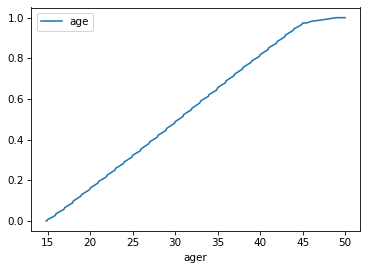

<IPython.core.display.Javascript object>

In [14]:
cdf = Cdf.from_seq(sample["ager"], name="age")
cdf.plot()
decorate()

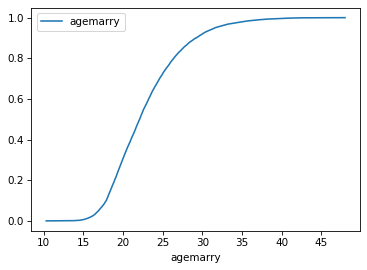

<IPython.core.display.Javascript object>

In [15]:
cdf = Cdf.from_seq(sample["agemarry"], name="agemarry")
cdf.plot()
decorate()

In [16]:
from utils import make_kmf_map

<IPython.core.display.Javascript object>

In [17]:
evrmarry = sample["evrmarry"]
sample["observed"] = evrmarry
sample.loc[evrmarry, "duration"] = sample["agemarry"]
sample.loc[~evrmarry, "duration"] = sample["ager"]

<IPython.core.display.Javascript object>

In [18]:
grouped = sample.groupby("birth_index")
nsfg_map = make_kmf_map(grouped)

<IPython.core.display.Javascript object>

In [19]:
from utils import add_text

<IPython.core.display.Javascript object>

In [20]:
def make_title(title, subtitle, pad=30):
    plt.title(title, loc="left", pad=pad)
    add_text(0, 1.085, subtitle)
    add_text(0, 1.015, "Analysis: allendowney.com/blog")

<IPython.core.display.Javascript object>

In [21]:
def decorate_plot(subtitle="", **options):
    decorate(
        xlabel="Age",
        ylabel="Percent",
        xlim=[13, 55],
        **options,
    )
    title = "Percent ever married"
    make_title(title, subtitle)

<IPython.core.display.Javascript object>

In [22]:
def plot_kmf_map(ax, kmf_map, cohorts, **options):
    """ """
    palette = set_palette("nipy_spectral", len(cohorts), reverse=True)
    for cohort in cohorts:
        series = kmf_map[cohort]
        label = f"{cohort+1900}s"
        series.plot(ax=ax, label=label, **options)
        label = ""

<IPython.core.display.Javascript object>

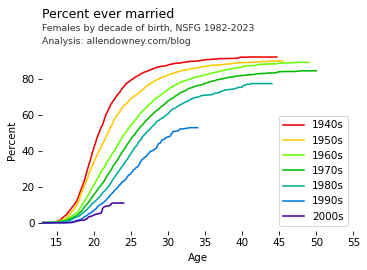

<IPython.core.display.Javascript object>

In [23]:
cohorts = range(40, 110, 10)

fig, ax = plt.subplots()
plot_kmf_map(ax, nsfg_map, cohorts)
decorate_plot(subtitle="Females by decade of birth, NSFG 1982-2023")
remove_spines()
plt.tight_layout()

In [24]:
def make_kmf_series(unweighted, iters=21):
    kmf_series = {}

    for i in range(iters):
        sample = resample_by_cycle(unweighted)
        sample = drop_missing(sample)
        evrmarry = sample["evrmarry"]
        sample["observed"] = evrmarry
        sample.loc[evrmarry, "duration"] = sample["agemarry"]
        sample.loc[~evrmarry, "duration"] = sample["ager"]
        grouped = sample.groupby("birth_index")
        kmf_map = make_kmf_map(grouped)
        for cohort in kmf_map:
            kmf_series.setdefault(cohort, []).append(kmf_map[cohort])

    return kmf_series

<IPython.core.display.Javascript object>

In [25]:
from utils import adjust_legend


def plot_kmf_series(kmf_series, cohorts, subtitle):
    # always make 7 colors, but only use the last n of them
    palette = sns.color_palette("nipy_spectral", 7)
    palette.reverse()
    n = len(cohorts)
    palette = palette[-n:]

    options = dict(alpha=0.1)

    for i, cohort in enumerate(cohorts):
        label = f"{cohort+1900}s"
        series_list = kmf_series[cohort]
        coords = []
        for series in series_list:
            coords.append((series.index[-1], series.iloc[-1]))
            series.plot(label=label, color=palette[i], **options)
            # only label the first line
            label = ""

    decorate_plot(subtitle, loc="lower right")
    adjust_legend(alpha=1, lw=2)
    remove_spines()
    plt.tight_layout()

<IPython.core.display.Javascript object>

In [26]:
kmf_series = make_kmf_series(unweighted)

<IPython.core.display.Javascript object>

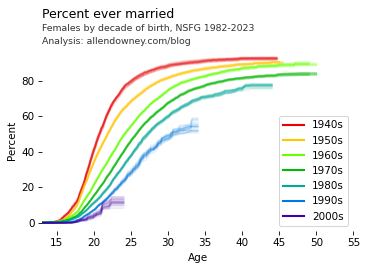

<IPython.core.display.Javascript object>

In [27]:
plot_kmf_series(
    kmf_series, cohorts, subtitle="Females by decade of birth, NSFG 1982-2023"
)
plt.savefig("marriage_female23.png", dpi=300)

## Age at first marriage, male respondents

Load the data cleaned in `clean_nsfg.ipynb` and run the analysis with `lifelines`

In [28]:
%time unweighted2 = pd.read_hdf('MaleMarriageData.hdf', 'MaleMarriageData')
unweighted.shape

CPU times: user 13.2 ms, sys: 4.36 ms, total: 17.6 ms
Wall time: 17.2 ms


(75769, 43)

<IPython.core.display.Javascript object>

In [29]:
evrmarry = unweighted2["evrmarry"]
value_counts(evrmarry)

evrmarry
False    24634
True     14135
Name: count, dtype: int64

<IPython.core.display.Javascript object>

In [30]:
for name, group in unweighted2.groupby("birth_index"):
    missing = group["evrmarry"] & group["agemarry"].isna()
    print(name, missing.sum())

50 0
60 0
70 1
80 1
90 1
100 0


<IPython.core.display.Javascript object>

In [31]:
sample = resample_by_cycle(unweighted2)

<IPython.core.display.Javascript object>

In [32]:
value_counts(sample["birth_index"])

birth_index
50       363
60      5003
70     11092
80     12007
90      8307
100     1997
Name: count, dtype: int64

<IPython.core.display.Javascript object>

In [33]:
sample = drop_missing(sample)

missing = sample["evrmarry"] & sample["agemarry"].isna()
missing.sum()

0

<IPython.core.display.Javascript object>

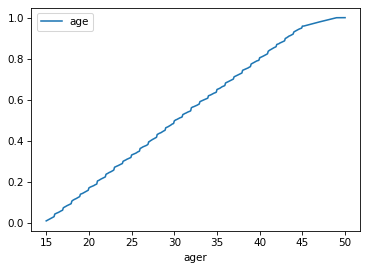

<IPython.core.display.Javascript object>

In [34]:
cdf = Cdf.from_seq(sample["ager"], name="age")
cdf.plot()
decorate()

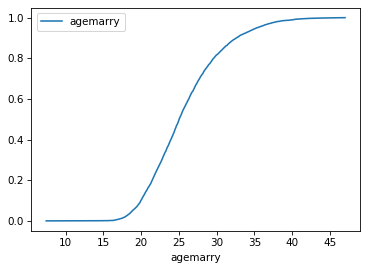

<IPython.core.display.Javascript object>

In [35]:
cdf = Cdf.from_seq(sample["agemarry"], name="agemarry")
cdf.plot()
decorate()

In [36]:
evrmarry = sample["evrmarry"]
sample["observed"] = evrmarry
sample.loc[evrmarry, "duration"] = sample["agemarry"]
sample.loc[~evrmarry, "duration"] = sample["ager"]

<IPython.core.display.Javascript object>

In [37]:
grouped = sample.groupby("birth_index")
nsfg_map = make_kmf_map(grouped)

<IPython.core.display.Javascript object>

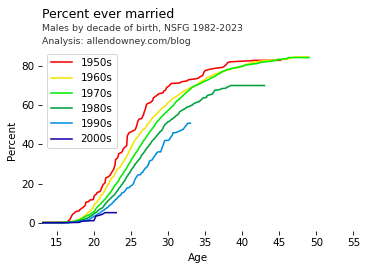

<IPython.core.display.Javascript object>

In [38]:
cohorts = range(50, 110, 10)

fig, ax = plt.subplots()
plot_kmf_map(ax, nsfg_map, cohorts)

decorate_plot(subtitle="Males by decade of birth, NSFG 1982-2023")
remove_spines()
plt.tight_layout()

In [39]:
kmf_series = make_kmf_series(unweighted2)

<IPython.core.display.Javascript object>

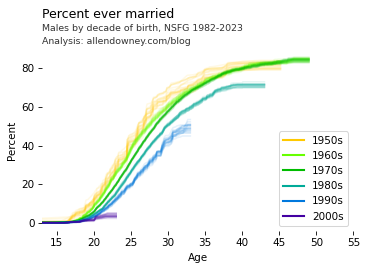

<IPython.core.display.Javascript object>

In [40]:
plot_kmf_series(
    kmf_series, cohorts, subtitle="Males by decade of birth, NSFG 1982-2023"
)
plt.savefig("marriage_male23.png", dpi=300)